## projekt wykonał Przemysław Klejno

### Wersje uytych pakietów:
python - 3.12.2
numpy - 1.26.4
matplotlib -  3.8.4
pandas - 2.2.2
tensorflow - 2.16.1

In [24]:
import numpy as np # algebra liniowa
import matplotlib.pyplot as plt # używane do rysowania wykresów
from sklearn.datasets import load_digits # importowanie zbioru danych
from sklearn.model_selection import train_test_split # podział danych na część treningową i testową
from sklearn.preprocessing import MinMaxScaler # normalizacja danych
from sklearn.preprocessing import OneHotEncoder # kodowanie one-hot
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import optuna # do hiperparametryzacji
import warnings # ignorowanie ostrzeżeń
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")


In [25]:
image_size = (64, 64)

def load_train_data(input_dir, newSize=(64,64)):
    '''
    '''

    
    import numpy as np
    import pandas as pd
    import os
    from skimage.io import imread
    import cv2 as cv
    from pathlib import Path
    import random
    from shutil import copyfile, rmtree
    import json


    import seaborn as sns
    import matplotlib.pyplot as plt

    import matplotlib
    
    image_dir = Path(input_dir)
    categories_name = []
    for file in os.listdir(image_dir):
        d = os.path.join(image_dir, file)
        if os.path.isdir(d):
            categories_name.append(file)

    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]

    train_img = []
    categories_count=[]
    labels=[]
    for i, direc in enumerate(folders):
        count = 0
        for obj in direc.iterdir():
            if os.path.isfile(obj) and os.path.basename(os.path.normpath(obj)) != 'desktop.ini':
                labels.append(os.path.basename(os.path.normpath(direc)))
                count += 1
                img = imread(obj)#zwraca ndarry postaci xSize x ySize x colorDepth
                img = cv.resize(img, newSize, interpolation=cv.INTER_AREA)# zwraca ndarray
                img = img / 255#normalizacja
                train_img.append(img)
        categories_count.append(count)
    X={}
    X["values"] = np.array(train_img)
    X["categories_name"] = categories_name
    X["categories_count"] = categories_count
    X["labels"]=labels
    return X

In [26]:
def load_test_data(input_dir, newSize=(64,64)):
    '''
    '''

    import numpy as np
    import pandas as pd
    import os
    from skimage.io import imread
    import cv2 as cv
    from pathlib import Path
    import random
    from shutil import copyfile, rmtree
    import json


    import seaborn as sns
    import matplotlib.pyplot as plt

    import matplotlib



    image_path = Path(input_dir)

    labels_path = image_path.parents[0] / 'test_labels.json'

    #with labels_path.open("r", encoding ="utf-8") as f:
    jsonString = labels_path.read_text()
    objects = json.loads(jsonString)

    #print(objects)

    categories_name = []
    categories_count=[]
    count = 0
    c = objects[0]['value']
    for e in  objects:
        if e['value'] != c:
            #print(count)
            #print(c)
            categories_count.append(count)
            c = e['value']
            count = 1
        else:
            count += 1
        if not e['value'] in categories_name:
            categories_name.append(e['value'])

    categories_count.append(count)



    test_img = []

    labels=[]
    for e in objects:
        p = image_path / e['filename']
        img = imread(p)#zwraca ndarry postaci xSize x ySize x colorDepth
        img = cv.resize(img, newSize, interpolation=cv.INTER_AREA)# zwraca ndarray
        img = img / 255#normalizacja
        test_img.append(img)
        labels.append(e['value'])


    X={}
    X["values"] = np.array(test_img)
    X["categories_name"] = categories_name
    X["categories_count"] = categories_count
    X["labels"]=labels
    return X



In [27]:
class NeuralNetwork:
    """
    Prosta sieć neuronowa z jedną warstwą ukrytą.

    Parametry:
    -----------
    input_size: int
        Liczba cech wejściowych
    hidden_size: int
        Liczba neuronów w warstwie ukrytej
    output_size: int
        Liczba neuronów w warstwie wyjściowej
    loss_func: str
        Funkcja straty do użycia. Opcje to 'mse' dla błędu średniokwadratowego, 'log_loss' dla straty logistycznej i 'categorical_crossentropy' dla krzyżowej entropii kategorycznej.
    """
    def __init__(self, input_size, hidden_size, output_size, loss_func='mse'):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.loss_func = loss_func
        
        # Inicjalizacja wag i przesunięć
        self.weights1 = np.random.randn(self.input_size, self.hidden_size)
        self.bias1 = np.zeros((1, self.hidden_size))
        self.weights2 = np.random.randn(self.hidden_size, self.output_size)
        self.bias2 = np.zeros((1, self.output_size))

        # Śledzenie straty
        self.train_loss = []
        self.test_loss = []

    def __str__(self):
        """
        Wyświetl architekturę sieci neuronowej.
        """
        return f"Układ Sieci Neuronowej:\nWarstwa Wejściowa: {self.input_size} neuronów\nWarstwa Ukryta: {self.hidden_size} neuronów\nWarstwa Wyjściowa: {self.output_size} neuronów\nFunkcja Straty: {self.loss_func}"
        
    def forward(self, X):
        """
        Przeprowadź propagację w przód.
        
        Parametry:
        -----------
        X: numpy array
            Dane wejściowe
        
        Zwraca:
        --------
        numpy array
            Przewidziane wyjście
        """
        # Przeprowadź propagację w przód
        self.z1 = np.dot(X, self.weights1) + self.bias1
        self.a1 = self.sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.weights2) + self.bias2
        if self.loss_func == 'categorical_crossentropy':
            self.a2 = self.softmax(self.z2)
        else:
            self.a2 = self.sigmoid(self.z2)
        return self.a2
    
    def backward(self, X, y, learning_rate):
        """
        Przeprowadź propagację wsteczną.

        Parametry:
        -----------
        X: numpy array
            Dane wejściowe
        y: numpy array
            Docelowe wyjście
        learning_rate: float
            Współczynnik uczenia
        """
        # Przeprowadź propagację wsteczną
        m = X.shape[0]
        
        # Oblicz gradienty
        if self.loss_func == 'mse':
            self.dz2 = self.a2 - y
        elif self.loss_func == 'log_loss':
            self.dz2 = -(y/self.a2 - (1-y)/(1-self.a2))
        elif self.loss_func == 'categorical_crossentropy':
            self.dz2 = self.a2 - y
        else:
            raise ValueError('Nieprawidłowa funkcja straty')
        
        self.dw2 = (1 / m) * np.dot(self.a1.T, self.dz2)
        self.db2 = (1 / m) * np.sum(self.dz2, axis=0)
        self.dz1 = np.dot(self.dz2, self.weights2.T) * self.sigmoid_derivative(self.a1)
        self.dw1 = (1 / m) * np.dot(X.T, self.dz1)
        self.db1 = (1 / m) * np.sum(self.dz1, axis=0)
        
        # Zaktualizuj wagi i przesunięcia
        self.weights2 -= learning_rate * self.dw2
        self.bias2 -= learning_rate * self.db2
        self.weights1 -= learning_rate * self.dw1
        self.bias1 -= learning_rate * self.db1
        
    def sigmoid(self, x):
        """
        Funkcja aktywacji sigmoidalna.
        
        Parametry:
        -----------
        x: numpy array
            Dane wejściowe
        
        Zwraca:
        --------
        numpy array
            Wynik funkcji sigmoidalnej
        """
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        """
        Pochodna funkcji aktywacji sigmoidalnej.

        Parametry:
        -----------
        x: numpy array
            Dane wejściowe
        
        Zwraca:
        --------
        numpy array
            Wynik pochodnej funkcji sigmoidalnej
        """
        return x * (1 - x)
    
    def softmax(self, x):
        """
        Funkcja aktywacji softmax.

        Parametry:
        -----------
        x: numpy array
            Dane wejściowe
        
        Zwraca:
        --------
        numpy array
            Wynik funkcji softmax
        """
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps/np.sum(exps, axis=1, keepdims=True)

In [28]:
class Trainer:
    """
    Klasa do trenowania sieci neuronowej.

    Parametry:
    -----------
    model: NeuralNetwork
        Model sieci neuronowej do trenowania
    loss_func: str
        Funkcja straty do użycia. Opcje to 'mse' dla błędu średniokwadratowego, 'log_loss' dla straty logistycznej, i 'categorical_crossentropy' dla krzyżowej entropii kategorycznej.
    """
    def __init__(self, model, loss_func='mse'):
        self.model = model
        self.loss_func = loss_func
        self.train_loss = []
        self.test_loss = []

    def calculate_loss(self, y_true, y_pred):
        """
        Oblicz stratę.

        Parametry:
        -----------
        y_true: numpy array
            Prawdziwe wyjście
        y_pred: numpy array
            Przewidziane wyjście
        
        Zwraca:
        --------
        float
            Strata
        """
        if self.loss_func == 'mse':
            return np.mean((y_pred - y_true)**2)
        elif self.loss_func == 'log_loss':
            return -np.mean(y_true*np.log(y_pred) + (1-y_true)*np.log(1-y_pred))
        elif self.loss_func == 'categorical_crossentropy':
            return -np.mean(y_true*np.log(y_pred))
        else:
            raise ValueError('Nieprawidłowa funkcja straty')

    def train(self, X_train, y_train, X_test, y_test, epochs, learning_rate):
        """
        Trenuj sieć neuronową.

        Parametry:
        -----------
        X_train: numpy array
            Dane wejściowe treningowe
        y_train: numpy array
            Docelowe wyjście treningowe
        X_test: numpy array
            Dane wejściowe testowe
        y_test: numpy array
            Docelowe wyjście testowe
        epochs: int
            Liczba epok trenowania modelu
        learning_rate: float
            Współczynnik uczenia
        """
        for _ in range(epochs):
            self.model.forward(X_train)
            self.model.backward(X_train, y_train, learning_rate)
            train_loss = self.calculate_loss(y_train, self.model.a2)
            self.train_loss.append(train_loss)
            
            self.model.forward(X_test)
            test_loss = self.calculate_loss(y_test, self.model.a2)
            self.test_loss.append(test_loss)

In [29]:
# enhance data function
def enhance_train_data(x_to_augment, y_to_augment):
   augmented_images = []
   augmented_labels = []

   for image,label in zip(x_to_augment, y_to_augment):
        augmented_images.append(image)
        augmented_labels.append(label)
        for _ in range(10):
           augmented = augment(image)
           augmented_images.append(augmented.numpy())
           augmented_labels.append(label)
   
   return augmented_images, augmented_labels


def augment(image):
    import tensorflow as tf
    delta = 0.09 # maximum relative change in brigtness
    
    image = tf.cast(image, tf.float64)
    image = tf.image.random_brightness(image, delta)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_contrast(image, 0.8, 1.2)

    return image

In [30]:
# load train data
data_train = load_train_data('./train_test_sw/train_sw')
x_train = data_train['values']
y_train = data_train['labels']

data_test = load_test_data('./train_test_sw/test_sw')
x_test = data_test['values']
y_test = data_test['labels']

In [31]:
labelEncoder = LabelEncoder()
y_train_enc = labelEncoder.fit_transform(y_train)
y_test_enc = labelEncoder.transform(y_test)

y_train_onehot = pd.get_dummies(y_train_enc).values
y_test_onehot = pd.get_dummies(y_test_enc).values

In [32]:
input_layer_size = 64*64*4
hidden_layer_size = 128
output_layer_size = 5

model = NeuralNetwork(input_size=input_layer_size, hidden_size=hidden_layer_size, output_size=output_layer_size)

trainer = Trainer(model)

trainer.train(x_train.reshape(-1, input_layer_size), y_train_onehot.reshape(-1, output_layer_size), x_test.reshape(-1, input_layer_size), y_test_onehot.reshape(-1, output_layer_size), epochs=100, learning_rate=0.01)

In [33]:
# Przekonwertuj y_test z kodowania one-hot na etykiety
etykiety_y_test = np.argmax(y_test_onehot, axis=1)

# Oceń wydajność sieci neuronowej
prognozy = np.argmax(model.forward(x_test.reshape(-1, input_layer_size)), axis=1)
dokladnosc = np.mean(prognozy == etykiety_y_test)
print(f"Dokładność: {dokladnosc:.2%}")

Dokładność: 28.19%


## Wykres funkcji straty dla sieci, ilość cykli: 100, learning_rate=0.01, wymiary sieci neuronowej: 64x64x4 -> 128 -> 4, liczba zdjęć treningowych: 1027

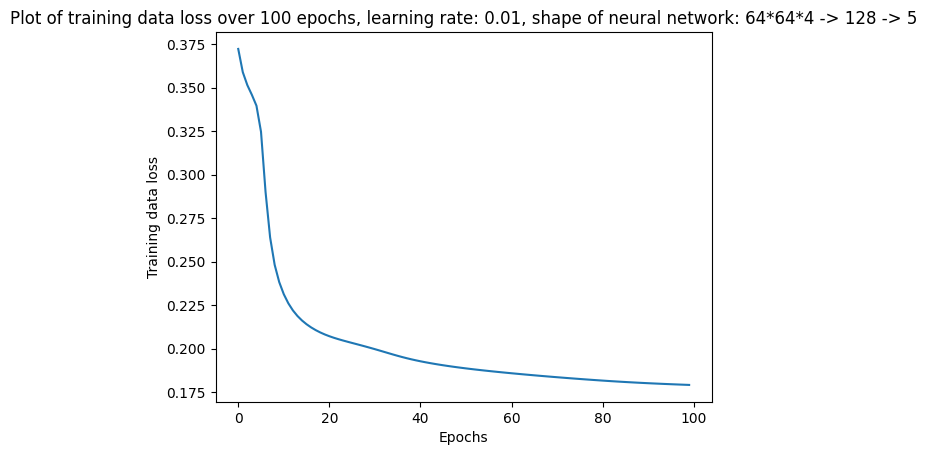

In [34]:
plt.plot(trainer.train_loss)
plt.xlabel('Epochs')
plt.ylabel('Training data loss')
plt.title('Plot of training data loss over 100 epochs, learning rate: 0.01, shape of neural network: 64*64*4 -> 128 -> 5')
plt.show()

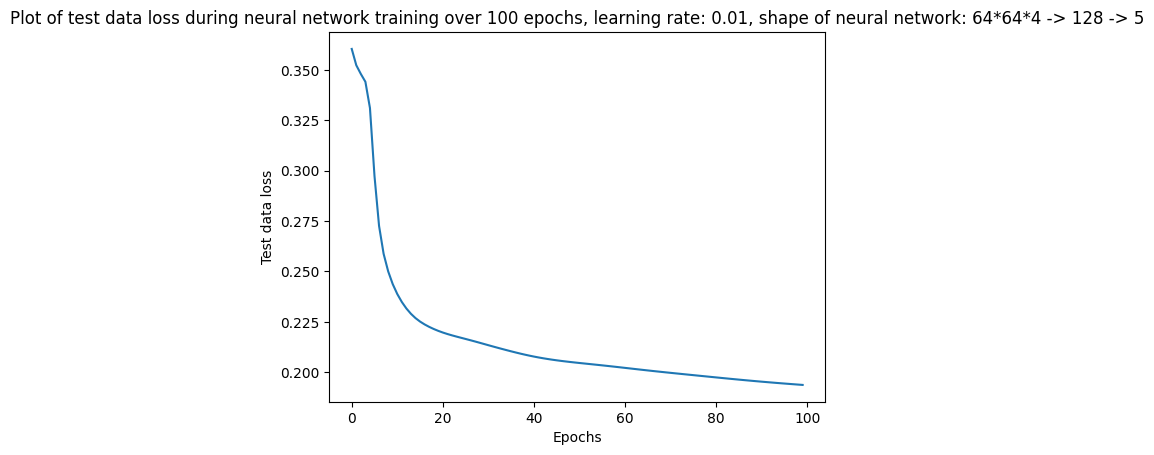

In [35]:
plt.plot(trainer.test_loss)
plt.xlabel('Epochs')
plt.ylabel('Test data loss')
plt.title('Plot of test data loss during neural network training over 100 epochs, learning rate: 0.01, shape of neural network: 64*64*4 -> 128 -> 5')
plt.show()

## Uczenie sieci ale z rozszerzeonymi danymi 10-krotnie:


### Kazde zdjecie dostanie 10 swoich kopii, ktore bedą np. odbite w poziomie co powinno pozwalić na ulepszenie sieci

In [36]:
print(f'Liczba zdjęć przed rozszerzeniem: {len(x_train)}')
augmented_x, augmented_y = enhance_train_data(x_train, y_train)
print(f'Liczba zdjęć po rozszerzeniu: {len(augmented_x)}')

Liczba zdjęć przed rozszerzeniem: 1027
Liczba zdjęć po rozszerzeniu: 11297


In [37]:
augmentedLabelEncoder = LabelEncoder()
augmented_y_train_enc = labelEncoder.fit_transform(augmented_y)
y_test_enc = labelEncoder.transform(y_test)

augmented_y_train_onehot = pd.get_dummies(augmented_y_train_enc).values
y_test_onehot = pd.get_dummies(y_test_enc).values

In [38]:
input_layer_size = 64*64*4
hidden_layer_size = 128
output_layer_size = 5

model_with_augmented_data = NeuralNetwork(input_size=input_layer_size, hidden_size=hidden_layer_size, output_size=output_layer_size)

trainer_with_augmented_data = Trainer(model_with_augmented_data)

trainer_with_augmented_data.train(np.array(augmented_x).reshape(-1, input_layer_size), augmented_y_train_onehot.reshape(-1, output_layer_size), x_test.reshape(-1, input_layer_size), y_test_onehot.reshape(-1, output_layer_size), epochs=100, learning_rate=0.01)

In [39]:
# Przekonwertuj y_test z kodowania one-hot na etykiety
rozszerzone_etykiety_y_test = np.argmax(y_test_onehot, axis=1)

# Oceń wydajność sieci neuronowej
prognozy = np.argmax(model_with_augmented_data.forward(x_test.reshape(-1, input_layer_size)), axis=1)
dokladnosc = np.mean(prognozy == etykiety_y_test)
print(f"Dokładność: {dokladnosc:.2%}")

Dokładność: 23.55%


## Wstępne wnioski z uczenia sieci neuronowej po zwiększeniu danych 10-krotnie, learning rate = 0.01, epochs = 100:
- Długość uczenia po zwiększeniu próbki danych 1-krotnie wzrosła z około 19 sekund do 2 minut 25 sekund
- Dokładność wzrosła z 22,39% do 23.55%

## Wykres funkcji straty dla sieci, ilość cykli: 100, learning_rate=0.01, wymiary sieci neuronowej: 64x64x4 -> 128 -> 4, liczba zdjęć treningowych: 11297


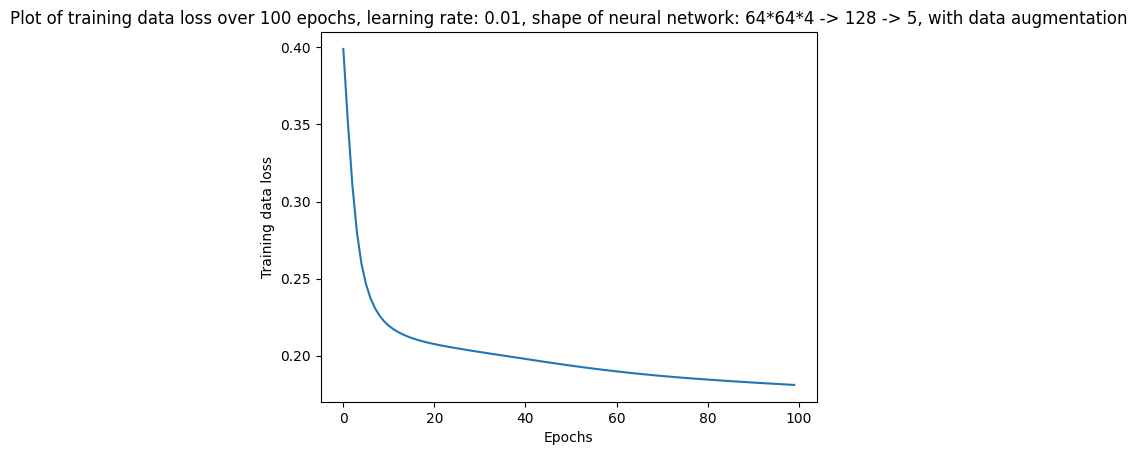

In [40]:
plt.plot(trainer_with_augmented_data.train_loss)
plt.xlabel('Epochs')
plt.ylabel('Training data loss')
plt.title('Plot of training data loss over 100 epochs, learning rate: 0.01, shape of neural network: 64*64*4 -> 128 -> 5, with data augmentation')
plt.show()

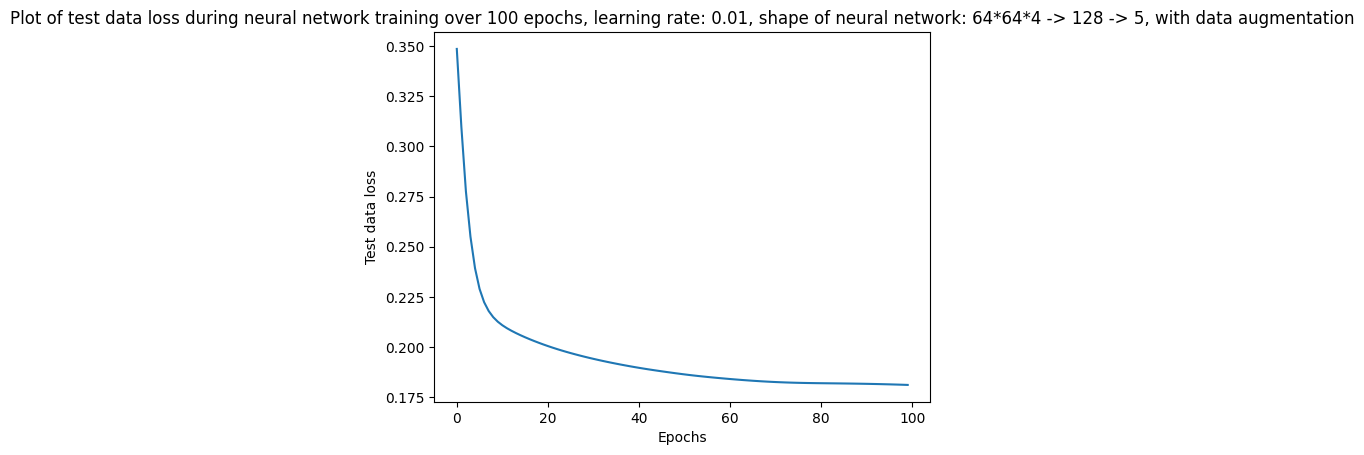

In [41]:
plt.plot(trainer_with_augmented_data.test_loss)
plt.xlabel('Epochs')
plt.ylabel('Test data loss')
plt.title('Plot of test data loss during neural network training over 100 epochs, learning rate: 0.01, shape of neural network: 64*64*4 -> 128 -> 5, with data augmentation')
plt.show()

## roszerzona ilość danych, ale liczba cykli zwiększona do 1000

In [42]:
input_layer_size = 64*64*4
hidden_layer_size = 128
output_layer_size = 5
epochs = 1000

model_with_augmented_data = NeuralNetwork(input_size=input_layer_size, hidden_size=hidden_layer_size, output_size=output_layer_size)

trainer_with_augmented_data = Trainer(model_with_augmented_data)

trainer_with_augmented_data.train(np.array(augmented_x).reshape(-1, input_layer_size), augmented_y_train_onehot.reshape(-1, output_layer_size), x_test.reshape(-1, input_layer_size), y_test_onehot.reshape(-1, output_layer_size), epochs=epochs, learning_rate=0.01)

In [43]:
# Przekonwertuj y_test z kodowania one-hot na etykiety
rozszerzone_etykiety_y_test = np.argmax(y_test_onehot, axis=1)

# Oceń wydajność sieci neuronowej
prognozy = np.argmax(model_with_augmented_data.forward(x_test.reshape(-1, input_layer_size)), axis=1)
dokladnosc = np.mean(prognozy == etykiety_y_test)
print(f"Dokładność: {dokladnosc:.2%}")

Dokładność: 30.50%


## Wykres funkcji straty dla sieci, ilość cykli: 1000, learning_rate=0.01, wymiary sieci neuronowej: 64x64x4 -> 128 -> 4, liczba zdjęć treningowych: 11297

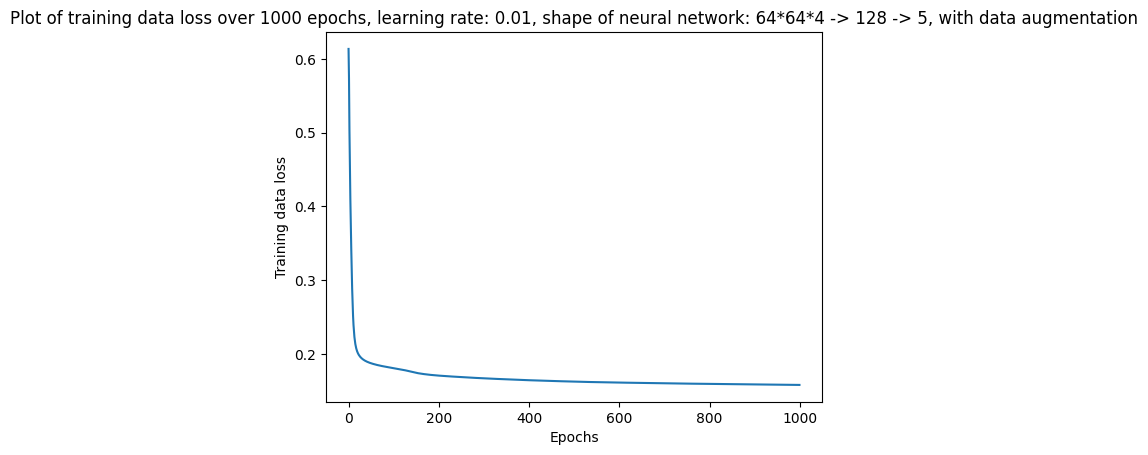

In [44]:
plt.plot(trainer_with_augmented_data.train_loss)
plt.xlabel('Epochs')
plt.ylabel('Training data loss')
plt.title('Plot of training data loss over 1000 epochs, learning rate: 0.01, shape of neural network: 64*64*4 -> 128 -> 5, with data augmentation')
plt.show()

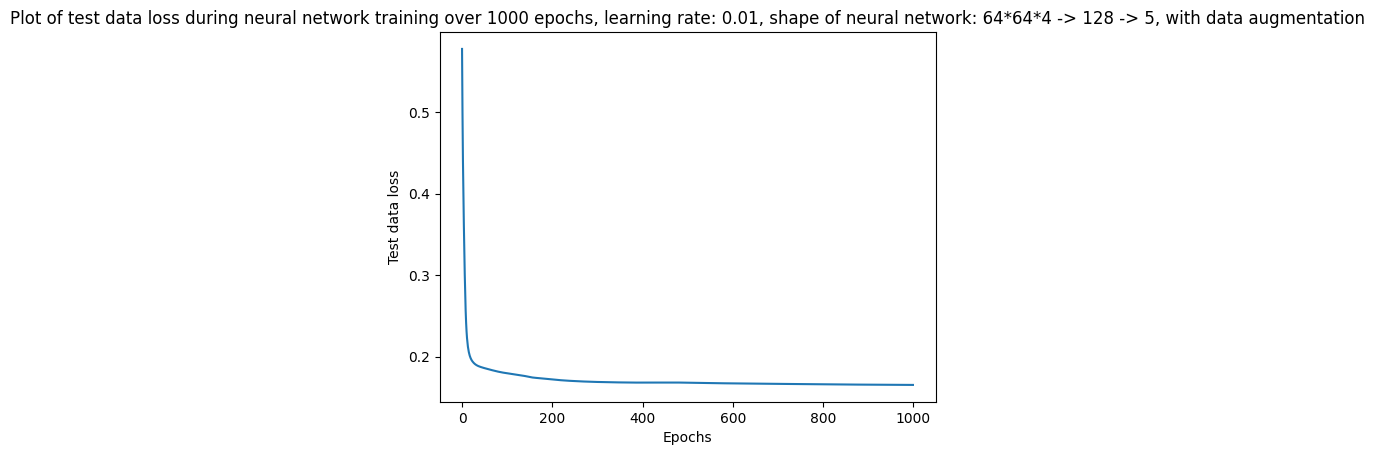

In [45]:
plt.plot(trainer_with_augmented_data.test_loss)
plt.xlabel('Epochs')
plt.ylabel('Test data loss')
plt.title('Plot of test data loss during neural network training over 1000 epochs, learning rate: 0.01, shape of neural network: 64*64*4 -> 128 -> 5, with data augmentation')
plt.show()

## Wnioski po 1000 cykli uczenia na roszerzonyych danych z learning rate 0.01:
- Dokładność: 27,83%
- Czas uczenia: 19 minut 32 sekundy

## Uczenie na roszerzonych danych, cykle: 100, learning rate: 0.05


In [46]:
input_layer_size = 64*64*4
hidden_layer_size = 128
output_layer_size = 5
epochs = 100
laerning_rate = 0.05

model_with_augmented_data = NeuralNetwork(input_size=input_layer_size, hidden_size=hidden_layer_size, output_size=output_layer_size)

trainer_with_augmented_data = Trainer(model_with_augmented_data)

trainer_with_augmented_data.train(np.array(augmented_x).reshape(-1, input_layer_size), augmented_y_train_onehot.reshape(-1, output_layer_size), x_test.reshape(-1, input_layer_size), y_test_onehot.reshape(-1, output_layer_size), epochs=epochs, learning_rate=laerning_rate)

In [47]:
# Przekonwertuj y_test z kodowania one-hot na etykiety
rozszerzone_etykiety_y_test = np.argmax(y_test_onehot, axis=1)

# Oceń wydajność sieci neuronowej
prognozy = np.argmax(model_with_augmented_data.forward(x_test.reshape(-1, input_layer_size)), axis=1)
dokladnosc = np.mean(prognozy == etykiety_y_test)
print(f"Dokładność: {dokladnosc:.2%}")

Dokładność: 27.03%


## Wykres funkcji straty dla sieci, ilość cykli: 100, learning_rate=0.05, wymiary sieci neuronowej: 64x64x4 -> 128 -> 4, liczba zdjęć treningowych: 11297


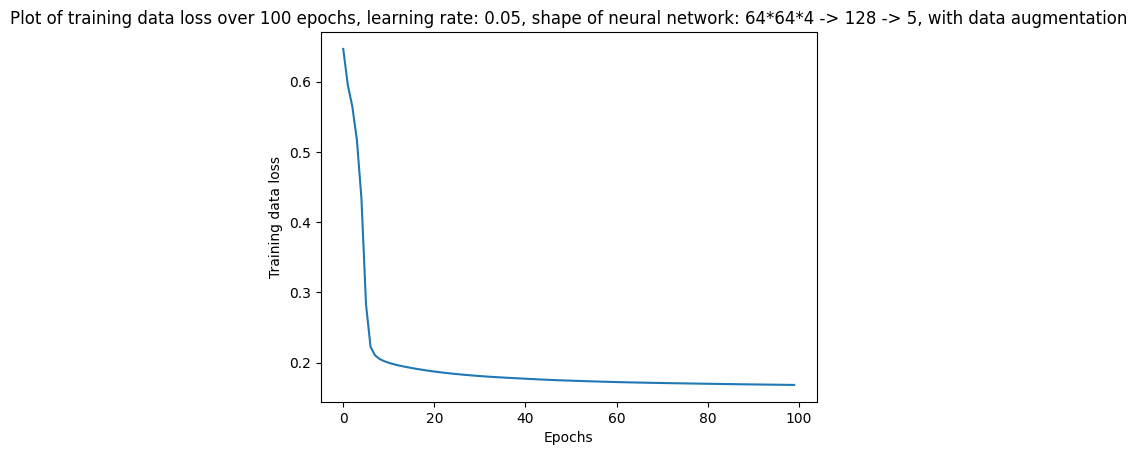

In [48]:
plt.plot(trainer_with_augmented_data.train_loss)
plt.xlabel('Epochs')
plt.ylabel('Training data loss')
plt.title('Plot of training data loss over 100 epochs, learning rate: 0.05, shape of neural network: 64*64*4 -> 128 -> 5, with data augmentation')
plt.show()

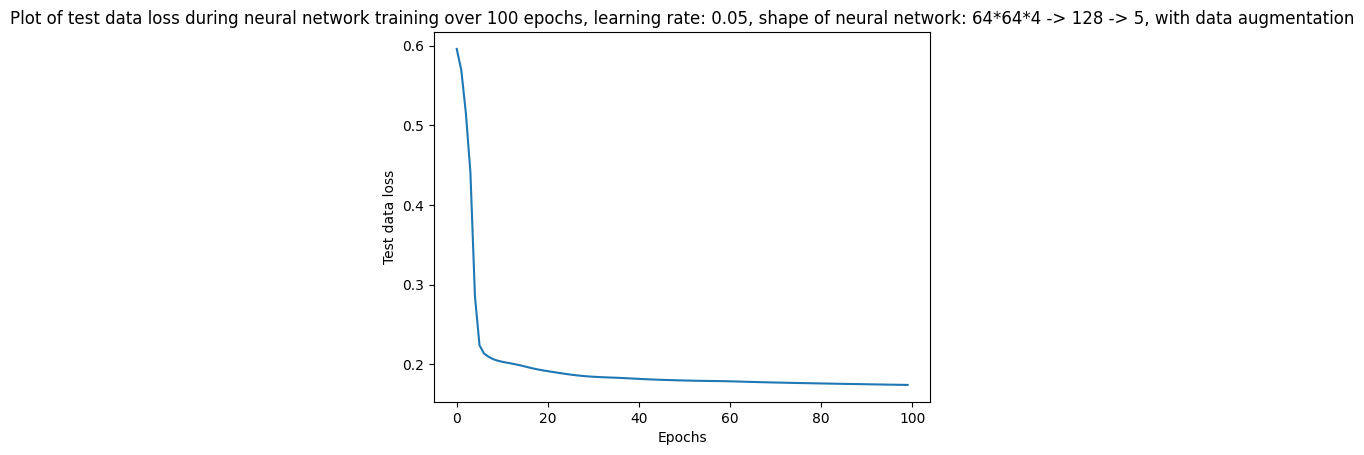

In [49]:
plt.plot(trainer_with_augmented_data.test_loss)
plt.xlabel('Epochs')
plt.ylabel('Test data loss')
plt.title('Plot of test data loss during neural network training over 100 epochs, learning rate: 0.05, shape of neural network: 64*64*4 -> 128 -> 5, with data augmentation')
plt.show()

In [50]:
input_layer_size = 64*64*4
hidden_layer_size = 128
output_layer_size = 5
epochs = 10000
laerning_rate = 0.001

model_with_augmented_data = NeuralNetwork(input_size=input_layer_size, hidden_size=hidden_layer_size, output_size=output_layer_size)

trainer_with_augmented_data = Trainer(model_with_augmented_data)

trainer_with_augmented_data.train(np.array(augmented_x).reshape(-1, input_layer_size), augmented_y_train_onehot.reshape(-1, output_layer_size), x_test.reshape(-1, input_layer_size), y_test_onehot.reshape(-1, output_layer_size), epochs=epochs, learning_rate=laerning_rate)

In [54]:
# Przekonwertuj y_test z kodowania one-hot na etykiety
rozszerzone_etykiety_y_test = np.argmax(y_test_onehot, axis=1)

# Oceń wydajność sieci neuronowej
prognozy = np.argmax(model_with_augmented_data.forward(x_test.reshape(-1, input_layer_size)), axis=1)
dokladnosc = np.mean(prognozy == etykiety_y_test)
print(f"Dokładność: {dokladnosc:.2%}")

Dokładność: 32.43%


## Wnioski po 10000 cykli oraz learning rate = 0.001
- uczenie sieci trwało 177 minut 38 sekund
- sioeć uczy się bardzo wolno, przez z taką ilością cykli mamy tylko 23,17% dokładności

## Wykres funkcji straty dla sieci, ilość cykli: 10000, learning_rate=0.001, wymiary sieci neuronowej: 64x64x4 -> 128 -> 4, liczba zdjęć treningowych: 11297


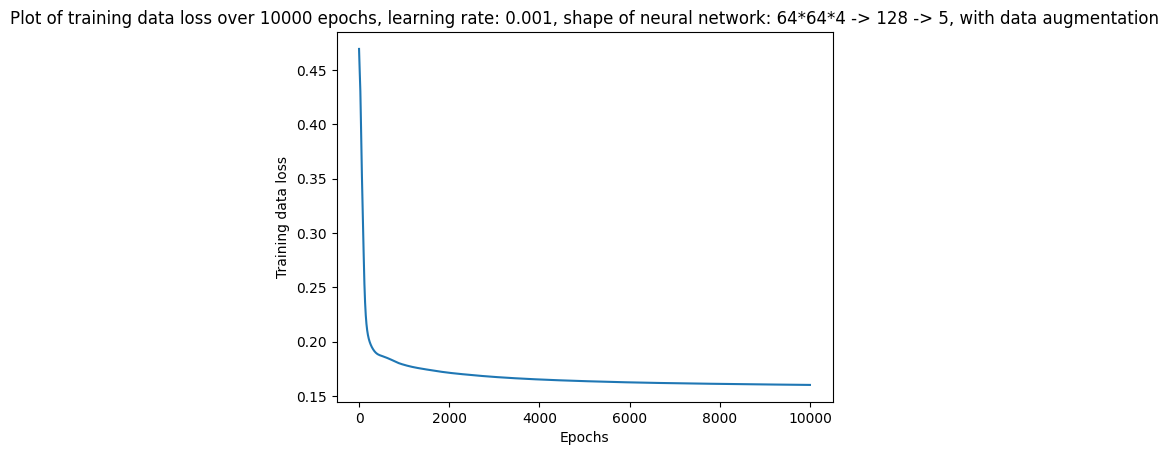

In [55]:
plt.plot(trainer_with_augmented_data.train_loss)
plt.xlabel('Epochs')
plt.ylabel('Training data loss')
plt.title('Plot of training data loss over 10000 epochs, learning rate: 0.001, shape of neural network: 64*64*4 -> 128 -> 5, with data augmentation')
plt.show()

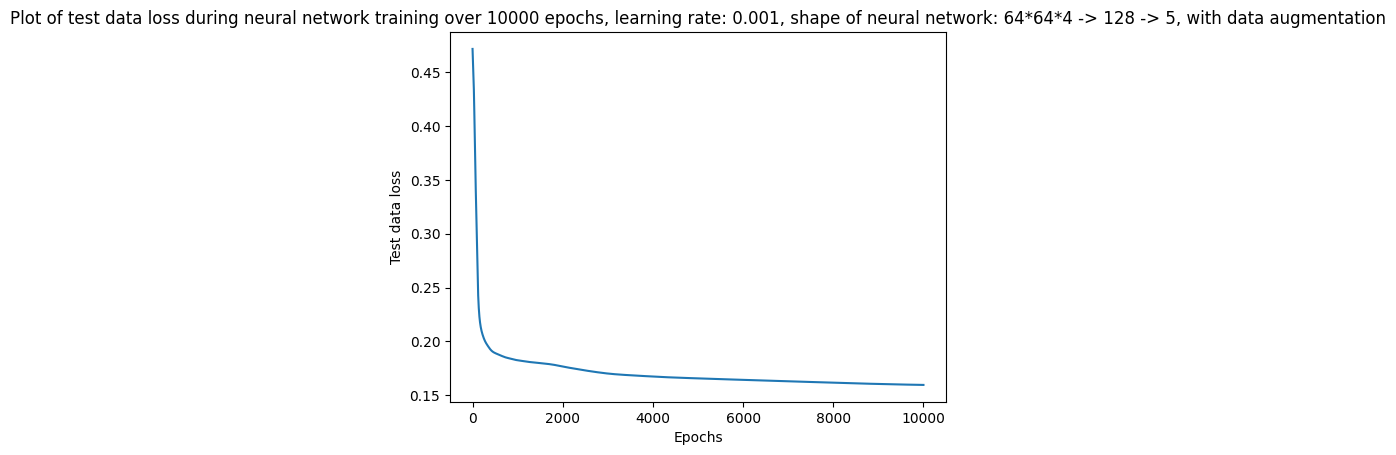

In [56]:
plt.plot(trainer_with_augmented_data.test_loss)
plt.xlabel('Epochs')
plt.ylabel('Test data loss')
plt.title('Plot of test data loss during neural network training over 10000 epochs, learning rate: 0.001, shape of neural network: 64*64*4 -> 128 -> 5, with data augmentation')
plt.show()

## Sieć neuronowa z funkcją straty: categorical crossentropy

In [57]:
input_layer_size = 64*64*4
hidden_layer_size = 128
output_layer_size = 5

model_with_augmented_data = NeuralNetwork(loss_func='categorical_crossentropy',input_size=input_layer_size, hidden_size=hidden_layer_size, output_size=output_layer_size)

trainer_with_augmented_data = Trainer(model_with_augmented_data)

trainer_with_augmented_data.train(np.array(augmented_x).reshape(-1, input_layer_size), augmented_y_train_onehot.reshape(-1, output_layer_size), x_test.reshape(-1, input_layer_size), y_test_onehot.reshape(-1, output_layer_size), epochs=100, learning_rate=0.01)

In [58]:
# Przekonwertuj y_test z kodowania one-hot na etykiety
rozszerzone_etykiety_y_test = np.argmax(y_test_onehot, axis=1)

# Oceń wydajność sieci neuronowej
prognozy = np.argmax(model_with_augmented_data.forward(x_test.reshape(-1, input_layer_size)), axis=1)
dokladnosc = np.mean(prognozy == etykiety_y_test)
print(f"Dokładność: {dokladnosc:.2%}")

Dokładność: 25.10%


## wykresy funkcji straty dla sieci neuronowej z funkcją straty: categorical crossentropy

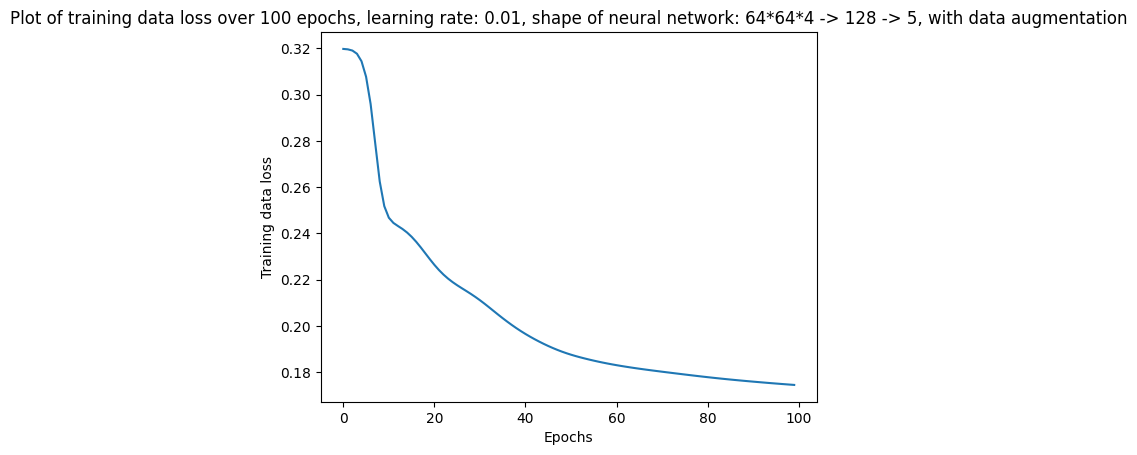

In [59]:
plt.plot(trainer_with_augmented_data.train_loss)
plt.xlabel('Epochs')
plt.ylabel('Training data loss')
plt.title('Plot of training data loss over 100 epochs, learning rate: 0.01, shape of neural network: 64*64*4 -> 128 -> 5, with data augmentation')
plt.show()

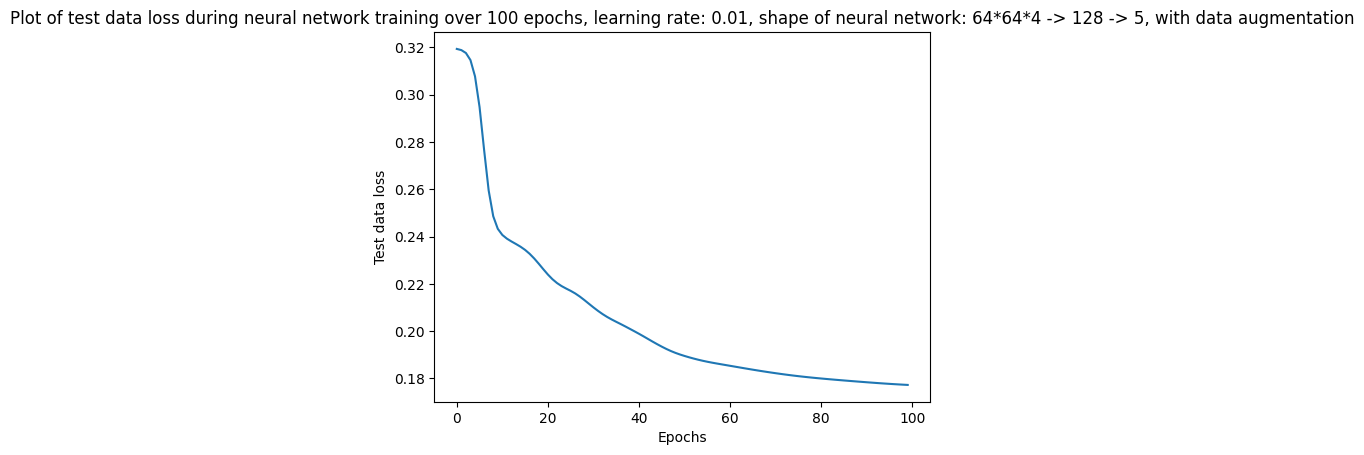

In [60]:
plt.plot(trainer_with_augmented_data.test_loss)
plt.xlabel('Epochs')
plt.ylabel('Test data loss')
plt.title('Plot of test data loss during neural network training over 100 epochs, learning rate: 0.01, shape of neural network: 64*64*4 -> 128 -> 5, with data augmentation')
plt.show()

## Sieć neuronowa z learning rate 1.25, dla sprawdzenia rysowania tkz. piły

In [61]:
input_layer_size = 64*64*4
hidden_layer_size = 128
output_layer_size = 5
epochs = 100
laerning_rate = 1.25

model_with_augmented_data = NeuralNetwork(input_size=input_layer_size, hidden_size=hidden_layer_size, output_size=output_layer_size)

trainer_with_augmented_data = Trainer(model_with_augmented_data)

trainer_with_augmented_data.train(np.array(augmented_x).reshape(-1, input_layer_size), augmented_y_train_onehot.reshape(-1, output_layer_size), x_test.reshape(-1, input_layer_size), y_test_onehot.reshape(-1, output_layer_size), epochs=epochs, learning_rate=laerning_rate)

In [62]:
# Przekonwertuj y_test z kodowania one-hot na etykiety
rozszerzone_etykiety_y_test = np.argmax(y_test_onehot, axis=1)

# Oceń wydajność sieci neuronowej
prognozy = np.argmax(model_with_augmented_data.forward(x_test.reshape(-1, input_layer_size)), axis=1)
dokladnosc = np.mean(prognozy == etykiety_y_test)
print(f"Dokładność: {dokladnosc:.2%}")

Dokładność: 22.39%


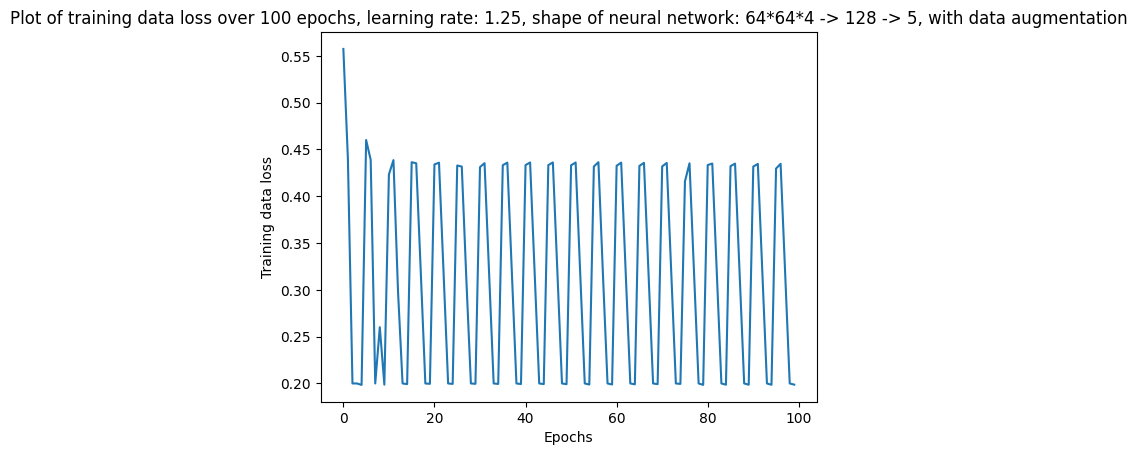

In [63]:
plt.plot(trainer_with_augmented_data.train_loss)
plt.xlabel('Epochs')
plt.ylabel('Training data loss')
plt.title('Plot of training data loss over 100 epochs, learning rate: 1.25, shape of neural network: 64*64*4 -> 128 -> 5, with data augmentation')
plt.show()

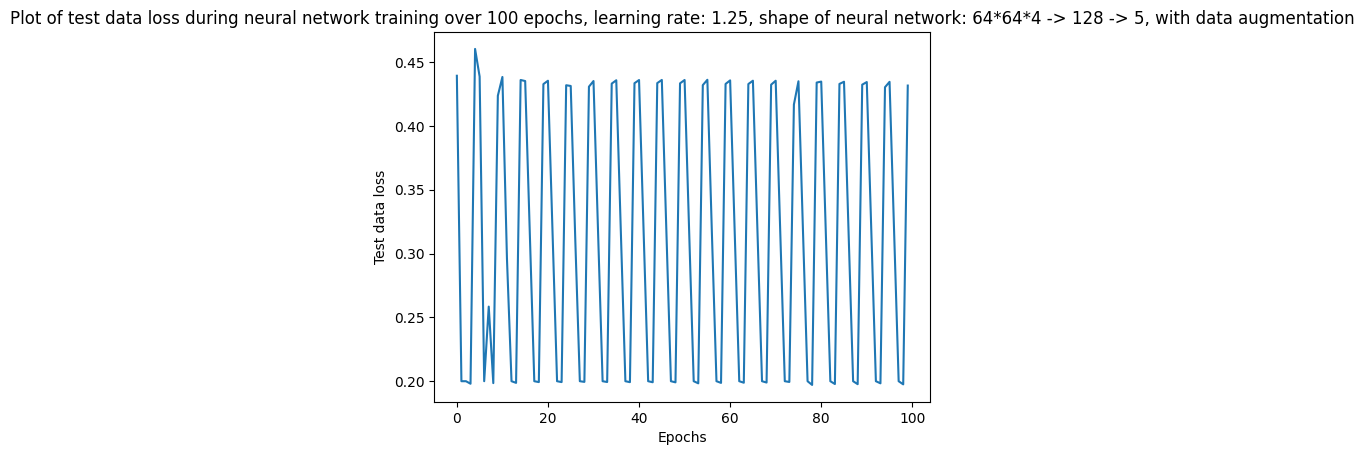

In [64]:
plt.plot(trainer_with_augmented_data.test_loss)
plt.xlabel('Epochs')
plt.ylabel('Test data loss')
plt.title('Plot of test data loss during neural network training over 100 epochs, learning rate: 1.25, shape of neural network: 64*64*4 -> 128 -> 5, with data augmentation')
plt.show()